In [ ]:
import os
import gc
import copy
import time
import random
import joblib
import requests
from io import BytesIO
from PIL import Image
from torchvision import transforms
from transformers import BertTokenizer
from PIL import Image, UnidentifiedImageError

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, default_collate

# Utils
from tqdm import tqdm
from collections import defaultdict

# For Transformer Models
from transformers import AutoProcessor, AdamW
from transformers import BlipForConditionalGeneration

## 데이터 불러오기

In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [ ]:
from datasets import load_dataset

dataset = load_dataset("visheratin/laion-coco-nllb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/14906 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/878978 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    test: Dataset({
        features: ['id', 'url', 'eng_caption', 'captions', 'score'],
        num_rows: 14906
    })
    train: Dataset({
        features: ['id', 'url', 'eng_caption', 'captions', 'score'],
        num_rows: 878978
    })
})

In [ ]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [ ]:
train_dataset

Dataset({
    features: ['id', 'url', 'eng_caption', 'captions', 'score'],
    num_rows: 878978
})

## 이미지 및 텍스트 전처리 함수

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration

# processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import BlipForConditionalGeneration, AutoProcessor

# Config 설정
CONFIG = {
    "seed": 2024,
    "epochs": 5,
    "model_name": "Salesforce/blip-image-captioning-base",
    "train_batch_size": 8,
    "valid_batch_size": 8,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
}

CONFIG["processor"] = AutoProcessor.from_pretrained(CONFIG['model_name'])

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    return default_collate(batch)

In [ ]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image_id = item["id"]
        image_url = f"https://nllb-data.com/{image_id}.jpg"

        caption = None
        for cap in item["captions"]:
            if cap[0] == 'kor_Hang':
                caption = cap[1]
                break

        if caption is None:
            return None

        try:
            response = requests.get(image_url)
            response.raise_for_status()  # Check if request was successful
            image = Image.open(BytesIO(response.content)).convert("RGB")
        except (requests.exceptions.RequestException, UnidentifiedImageError) as e:
            print(f"Error loading image at index {idx} from URL {image_url}: {e}")
            return None

        image = image.resize((224, 224))

        encoding = self.processor(images=image, text=caption, padding="max_length", return_tensors="pt")
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding['image_ids'] = image_id  # Image ID 추가
        encoding['captions'] = caption  # 캡션 추가
        return encoding

In [ ]:
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    return default_collate(batch)

# 데이터셋 로드
train_dataset = dataset['train']
test_dataset = dataset['test']

train_data = ImageCaptioningDataset(dataset['train'], CONFIG['processor'])
test_data = ImageCaptioningDataset(dataset['test'], CONFIG['processor'])

train_loader = DataLoader(train_data, batch_size=CONFIG['train_batch_size'], shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=CONFIG['valid_batch_size'], shuffle=False, collate_fn=collate_fn)

### 1% 데이터만 test

In [ ]:
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    return default_collate(batch)

from torch.utils.data import Subset
import random

# 데이터셋 로드
train_dataset = dataset['train']
test_dataset = dataset['test']

train_data = ImageCaptioningDataset(train_dataset, CONFIG['processor'])
test_data = ImageCaptioningDataset(test_dataset, CONFIG['processor'])

# train 데이터의 1%만 이용
num_samples = int(len(train_data) * 0.01)
subset_indices = random.sample(range(len(train_data)), num_samples)

te_num_samples = int(len(test_data) * 0.1)
te_subset_indices = random.sample(range(len(test_data)), te_num_samples)

# Subset을 사용하여 데이터셋의 일부분만 선택합니다.
train_subset = Subset(train_data, subset_indices)
test_subset = Subset(test_data, te_subset_indices)

# DataLoader 생성
train_loader = DataLoader(train_subset, batch_size=CONFIG['train_batch_size'], shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_subset, batch_size=CONFIG['valid_batch_size'], shuffle=False, collate_fn=collate_fn)

In [ ]:
# 모델 초기화
model = BlipForConditionalGeneration.from_pretrained(CONFIG['model_name'])
model.to(CONFIG['device'])

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])

best_model_state = None
best_loss = float('inf')  # Initialize with a high value

# 파인튜닝 루프
for epoch in range(CONFIG['epochs']):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_loader):
        images = batch['pixel_values'].to(CONFIG['device'])
        input_ids = batch['input_ids'].to(CONFIG['device'])
        attention_mask = batch['attention_mask'].to(CONFIG['device'])
        image_ids = batch['image_ids']  # 이미지 ID 가져오기

        print(f"Processing batch {step+1} in epoch {epoch+1}, Image IDs: {image_ids}")

        outputs = model(pixel_values=images, input_ids=input_ids, labels=input_ids, attention_mask=attention_mask)
        loss = outputs.loss

        total_loss += loss.item()

        loss.backward()

        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()
            optimizer.zero_grad()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{CONFIG['epochs']}, Loss: {avg_loss:.4f}")

    # 평가 단계 (선택사항)
    model.eval()
    with torch.no_grad():
        total_test_loss = 0
        for step, test_batch in enumerate(test_loader):
            images = test_batch['pixel_values'].to(CONFIG['device'])
            input_ids = test_batch['input_ids'].to(CONFIG['device'])
            attention_mask = test_batch['attention_mask'].to(CONFIG['device'])
            test_image_ids = test_batch['image_ids']  # 테스트 이미지 ID 가져오기

            print(f"Evaluating batch {step+1} in epoch {epoch+1}, Test Image IDs: {test_image_ids}")

            outputs = model(pixel_values=images, input_ids=input_ids, labels=input_ids, attention_mask=attention_mask)
            test_loss = outputs.loss
            total_test_loss += test_loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        print(f"Test Loss: {avg_test_loss:.4f}")

        # 현재의 모델이 이전에 저장한 모델보다 성능이 우수한 경우에만 모델 저장
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            best_model_state = model.state_dict()

# 가장 좋은 성능을 보이는 모델을 저장
if best_model_state is not None:
    torch.save(best_model_state, '/content/drive/MyDrive/Colab Notebooks/멋쟁이 사자 수업/model/best_blip_finetuned.pth')
    print("Best model saved.")
else:
    print("No improvement in test loss during training.")

Processing batch 1 in epoch 1, Image IDs: ['1476d765-0da1-42ac-97a3-252d810ac454', 'b4a018b8-aa53-4be3-a67f-6bdcf35ef60a', '9d65fb21-0219-43f1-aa5e-e2bea08344ab', '059329b9-985f-400a-8555-a17f5fec882e', 'fac31bbe-be09-4bb3-9788-e9fd695765f5', '3516d5f5-fca4-4934-aaa9-984a0f828267', '32d3fdb2-77f9-4a61-b8ea-d04cebc15293', '9d926104-cd6e-44ff-b0e1-8038dafee120']
Processing batch 2 in epoch 1, Image IDs: ['cc003880-785c-4d98-aaa2-25982160cebc', '32fb2e58-efc7-423c-ad9b-0c6596891bbf', '39dceb7c-a113-4de8-8258-9488b4d30cbf', '907be284-8e28-4936-8c95-1eea6a8c5fac', '57beb415-94da-4f4f-83b0-542b4e166d7e', 'aa037a51-b779-4222-967b-6858555f8c3a', '777b0772-4f3a-424a-a845-02917070ea12', '52b296e2-dcd5-4925-ab89-c86efd3ade87']
Processing batch 3 in epoch 1, Image IDs: ['9b27f1fb-a476-4c22-812d-51ab6f391c0a', 'dd9d9d2d-71d3-40f2-b70c-b3b7020c503d', '92f1d1f1-bad6-4d2e-a833-4118ee80733a', 'c0c41c10-14f0-478b-a3a1-acd762526cd8', '83c577dd-9667-4c2f-8bc5-731de09c192b', '24359d1d-3be2-4122-ac5e-94e5f3

In [ ]:
import matplotlib.pyplot as plt

# 모델 초기화
model = BlipForConditionalGeneration.from_pretrained(CONFIG['model_name'])
model.to(CONFIG['device'])

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])

best_model_state = None
best_loss = float('inf')  # Initialize with a high value

train_losses = []
test_losses = []

# 파인튜닝 루프
for epoch in range(CONFIG['epochs']):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_loader):
        images = batch['pixel_values'].to(CONFIG['device'])
        input_ids = batch['input_ids'].to(CONFIG['device'])
        attention_mask = batch['attention_mask'].to(CONFIG['device'])
        image_ids = batch['image_ids']  # 이미지 ID 가져오기
        captions = batch['captions']  # 캡션 가져오기

        # 이미지와 캡션 출력
        print(f"Processing batch {step+1} in epoch {epoch+1}, Image IDs and Captions:")
        for image_id, caption in zip(image_ids, captions):
            print(f"Image ID: {image_id}, Caption: {caption}")

        outputs = model(pixel_values=images, input_ids=input_ids, labels=input_ids, attention_mask=attention_mask)
        loss = outputs.loss

        total_loss += loss.item()

        loss.backward()

        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()
            optimizer.zero_grad()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{CONFIG['epochs']}, Loss: {avg_loss:.4f}")

    # 평가 단계 (선택사항)
    model.eval()
    with torch.no_grad():
        total_test_loss = 0
        for step, test_batch in enumerate(test_loader):
            images = test_batch['pixel_values'].to(CONFIG['device'])
            input_ids = test_batch['input_ids'].to(CONFIG['device'])
            attention_mask = test_batch['attention_mask'].to(CONFIG['device'])
            test_image_ids = test_batch['image_ids']  # 테스트 이미지 ID 가져오기
            test_captions = test_batch['captions']  # 테스트 캡션 가져오기

            print(f"Evaluating batch {step+1} in epoch {epoch+1}, Test Image IDs and Captions:")
            for image_id, caption in zip(test_image_ids, test_captions):
                print(f"Image ID: {image_id}, Caption: {caption}")

            outputs = model(pixel_values=images, input_ids=input_ids, labels=input_ids, attention_mask=attention_mask)
            test_loss = outputs.loss
            total_test_loss += test_loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f"Test Loss: {avg_test_loss:.4f}")

        # 현재의 모델이 이전에 저장한 모델보다 성능이 우수한 경우에만 모델 저장
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            best_model_state = model.state_dict()

# 가장 좋은 성능을 보이는 모델을 저장
if best_model_state is not None:
    torch.save(best_model_state, '/content/drive/MyDrive/Colab Notebooks/멋쟁이 사자 수업/model/best_blip_finetuned.pth')
    print("Best model saved.")
else:
    print("No improvement in test loss during training.")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Image ID: 4c99fee3-3f17-4390-9006-ac63df0fa70d, Caption: 나무 밑바닥이 있는 두 개의 테이블과 꽃이 그려진 테이블이 있습니다.
Image ID: f28a025a-2142-4185-89a8-2090b694de28, Caption: 텍스트가 덮인 베르사유 궁전.
Image ID: 769cb8cc-612c-4dc8-9b1d-722bfc2af162, Caption: 파란 그릇 에 옥수수 와 토마토 를 넣은 새우 파스타
Image ID: c7647119-bec3-4e39-af4c-cde4b845df6c, Caption: 회의 테이블 위 의 금속 소지 에 여러 장 의 펜
Image ID: 2a5739ce-55c1-4698-bfdf-e50eafcb31ab, Caption: 검은색 소파와 다채로운 그림이 있는 거실.
Image ID: 5437e46f-c252-4815-8d01-73189a9ca645, Caption: 바닥에 놓인 띠가 있는 가방.
Image ID: ce32130a-e397-41ec-8a2c-fdb80ed8bc85, Caption: HTC 폰의 뒷면과 옆면.
Image ID: 15fd1bf7-aac3-42f8-aa5f-ee0c8e054774, Caption: NASA의 후디는 파란색이고 오렌지 테이프가 붙어 있습니다.
Processing batch 731 in epoch 5, Image IDs and Captions:
Image ID: 945ba58f-26ff-42b5-a386-277ffec3f05c, Caption: 초록색 섬유망 직물입니다.
Image ID: 1662823e-34e5-4b41-a4f6-b138fded6614, Caption: JBL 헤드셋은 외부 마이크와 호환되도록 설계되었습니다.
Image ID: 554596b5-5804-4136-86eb-cd10974cb254, Caption: 백색 오키디아와 보라색 꽃은 사각형 유리 꽃병에.
I

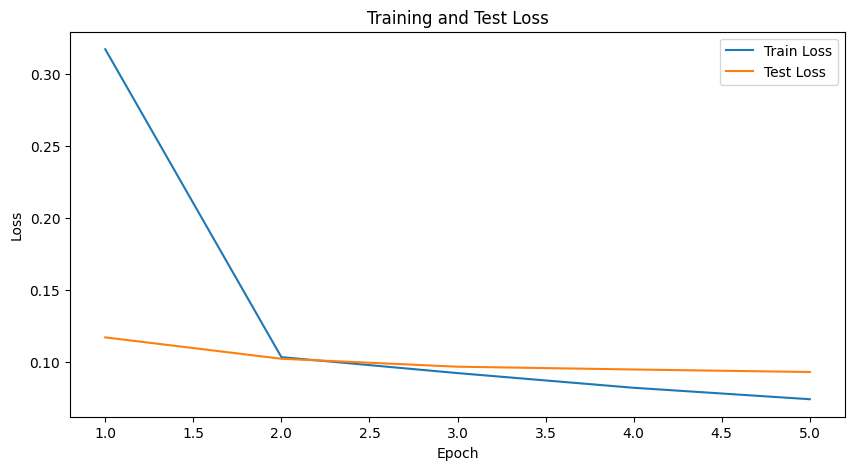

In [ ]:
# 손실 값 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(1, CONFIG['epochs'] + 1), train_losses, label='Train Loss')
plt.plot(range(1, CONFIG['epochs'] + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()